# Python library for the analysis of raw data from the SCiO

Note: The SCiO spectrometer is manufactured by Consumer Physics

### Questions regarding decoding:

- How many datapoints are there? 331 or 400? 400*4=
- What are the remaining data bytes?
- Is the data encrypted?
- Is the data gzipped?


### Calculate reflectance
- $correctedSample  = sample - sampleDark$
- $correctedGradient = sampleGradient - sampleDark$
- $reflectanceRAW = correctedSample / correctedGradient$

- $reflectance = reflectanceRAW / reflectanceWR$

In [1]:
import json
import struct
import datetime
import os
import csv
import base64
import numpy as np

from plotnine import *

In [30]:
class scio_analyse:
    def __init__(self):
        self.device_info = {}
        self.scan_rawdata = {}
        self.scan_b64data = {}
        self.temperature = {}
        
    def load_file(self, fn):
        # Load the JSON file
        with open(fn, 'r') as file:
            json_data = json.load(file)

        # Load the temperature object
        self.temperature = json_data['temperature']
        # Load the device information object
        self.device_info = json_data['device']
        # Load raw data as hex
        self.scan_rawdata = json_data['raw_data']
        # Load raw data as Base64
        self.scan_b64data = json_data['b64_data']
        return
    
    def encode_b64(self, bytestring):
        urlSafeEncodedBytes = base64.b64encode(bytestring)
        urlSafeEncodedStr = str(urlSafeEncodedBytes, 'utf-8')
        return(urlSafeEncodedStr)
    
    def switch_byte_order(self, bytestring):
        hex_str = bytestring.hex()
        out_str = ''
        for i in range(int(len(hex_str)/4)):
            out_str += hex_str[i*4+2] + hex_str[i*4+3]
            out_str += hex_str[i*4+0] + hex_str[i*4+1]
        hex_bytes = bytes.fromhex(out_str)
        return(hex_bytes)
    
    def b64_to_hex(self):
        self.scan_hexdata = {}
        for dict_key in self.scan_b64data.keys():
            if(dict_key == 'sampled_at'):
                self.scan_hexdata.update({dict_key: self.scan_b64data[dict_key]})
                continue
            if('numberOfCommandsPerSpectrum' in self.device_info.keys()):
                self.scan_hexdata.update({dict_key: base64.b64decode(self.scan_b64data[dict_key]).hex()})
            else:
                self.scan_hexdata.update({dict_key: base64.urlsafe_b64decode(self.scan_b64data[dict_key]).hex()})
        return

In [32]:
data_fn        = './01_rawdata/scan_json/scan_dark1.json'
# Create an instance and load data
scio = scio_analyse()
scio.load_file(data_fn)

# If you want to convert Base64 data to hex, for example to extract the white reference (WR) data, use the following.
# Note that the data will be stored in a new dict, called scio.scan_hexdata
scio.b64_to_hex()


# Show some data
print(len('8032AB45611198F1'))
print(scio.device_info)
print(len(scio.device_info['aptinaId']))
print(scio.scan_rawdata['sample'])

16
{'deviceBleId': '01665900004c99b4', 'bleFWVersion': 125, 'serial_number': 'CPPCA0031C6PF0516009W6404386A1DF1816004A', 'device_name': 'myScio', 'i2s_tag_config': '20150812-e:PRODUCTION', 'deviceDspId': 'e24da26b2304c2c0', 'aptinaId': '00004c8e3238c8e18032ab45611198f1', 'firmwareVersion': 147}
32
00000000e10d74de6b86120c8d6e8d49e96a77451d0590751104c51307a015b53f85137814d935b7e6a4f77743d417b10d81f00d9aa5274c427a4b9a6b291d99fc1d6e87e798b4375e7e5e9d563ea5e50292a6460e7b0927adffbd6e10e159c99bdba3ab3f7d9bf4351922f1c66f6f6f8076c8a155ed673fd14a264482f093fa00a03f5a7cf9faa4a4be8bb6cfb363bd411294761bf6104c0f0a0bafe0937fe2deb60c361163d647507c245c7d9ed22ee23cec2cf8767b601c1ae018aa946359ed399316132e5833f50bbbb610e017a4450dd685cca8ee27fdc521c0d4d16630cf1073fa02f3c12d95803a4ccf349f26af414f3ba73ab159beb5bbb2779eff2b2525e5fd4082a3d4489ffd4b93b371fbefa2b72900ef3c268f52270b91458acced42522519e924feb5d88090608e4dbfdf1f90ebaa8f6a407fafa6c8acd0d82f3cb87d110bd7b24c55dcbaecc3b69adf11745770ae43591374e4267503803

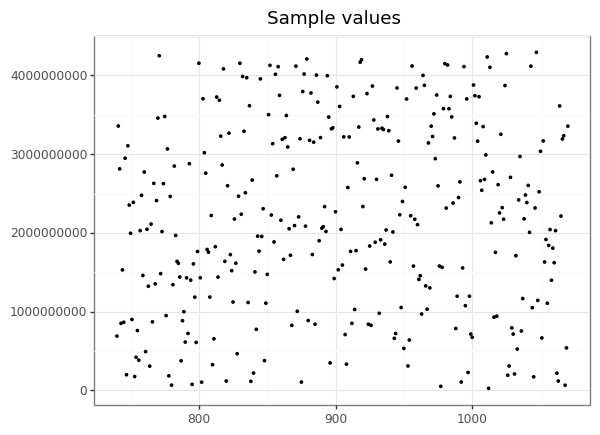

In [13]:
data_fn        = './01_rawdata/scan_json/scan_dark1.json'
# Create an instance and load data
scio = scio_analyse()
scio.load_file(data_fn)

smp = bytearray.fromhex(scio.scan_rawdata['sample_gradient'])

format_str = '<' + 332*'x' + 331*'I'
format_str = '<' + 300*'x' + 331*'I' + 32*'x'


sample_list = np.array(struct.unpack(format_str, smp))


#print('Bytes:', sample_bytes.hex())
#print('Data: ', sample_list)

plt = ggplot()
plt = plt + geom_point(aes(x=np.arange(len(sample_list))+740, y=sample_list), size=0.5)
plt = plt + theme_bw()
plt = plt + ggtitle('Sample values')
print(plt)

In [50]:
sample_hex         = '06 36 7b 2e 4f 3d 1c 0e 06 04 04 06'
sampleDark_hex     = '05 34 75 26 48 36 1c 0c 05 04 05 05'
sampleGradient_hex = '0b 4f 9c 3e 6c 4c 28 11 0a 09 0a 0c'

sample = np.array([int(x, 16) for x in sample_hex.split(' ')])
sampleDark = np.array([int(x, 16) for x in sampleDark_hex.split(' ')])
sampleGradient = np.array([int(x, 16) for x in sampleGradient_hex.split(' ')])

correctedSample = sample - sampleDark
correctedGradient = sampleGradient - sampleDark
reflectance = correctedSample / correctedGradient

print(correctedSample)
print(sample)
print(reflectance)

[ 1  2  6  8  7  7  0  2  1  0 -1  1]
[  6  54 123  46  79  61  28  14   6   4   4   6]
[ 0.16666667  0.07407407  0.15384615  0.33333333  0.19444444  0.31818182
  0.          0.4         0.2         0.         -0.2         0.14285714]


In [17]:
from Crypto.Cipher import AES

key = b'00004c8e3238c8e18032ab45611198f1'
cipher = AES.new(key, AES.MODE_ECB)

print(len(smp)/16)
decrypted_bytes = cipher.decrypt(smp)

print(decrypted_bytes.hex())

103.5


ValueError: Data must be aligned to block boundary in ECB mode

# Convert old scans to new format

In [35]:
class scio_update_old_scan_file:
    def __init__(self):
        self.device_info = {}
        self.scan_rawdata = {}
        self.scan_b64data = {}
        self.temperature = {}
        
    def load_file(self, fn):
        # Load the JSON file
        with open(fn, 'r') as file:
            json_data = json.load(file)

        # Load the "scan" object
        data = json_data['scan']
        # Load the device information object
        info = json_data['device']
        return(info, data)
    
    def store_data(self, info, data):
        # Store info
        self.device_info = info
        
        # Now temperature
        selected_keys = ['t_cmos_before', 't_chip_before', 't_obj_before', 't_cmos_after', 't_chip_after', 't_obj_after']
        self.temperature = {key: data[key] for key in selected_keys}
        self.temperature.update({'sampled_at': data['timestamp']})
        
        # Hex data
        selected_keys = ['sample', 'sample_dark', 'sample_gradient']
        self.scan_rawdata = {'sampled_at': data['timestamp']}
        self.scan_rawdata.update({key: base64.urlsafe_b64decode(data[key]).hex()  for key in selected_keys})
        
        # Base64 data
        selected_keys = ['sample', 'sample_dark', 'sample_gradient']
        self.scan_b64data = {'sampled_at': data['timestamp']}
        self.scan_b64data.update({key: data[key] for key in selected_keys})
        return
    
    # Saves a single scan as raw data to JSON
    def write_data_file(self, output_fn):
        # Create the json string
        jsondata = {}
        jsondata['device'] = self.device_info
        # Add temperature
        jsondata['temperature'] = self.temperature
        # Data, as hex and base64
        jsondata['raw_data'] = self.scan_rawdata
        jsondata['b64_data'] = self.scan_b64data
        
        # Write data to JSON file
        with open(output_fn, 'w') as outfile:
            json.dump(jsondata, outfile, indent=4)
        return
    
    def convert_file(self, input_fn, output_fn):
        info, data = self.load_file(input_fn)
        self.store_data(info, data)
        self.write_data_file(output_fn)
        return

In [36]:
import glob
directory = './01_rawdata/scan_json/'
# Now set up the instance
scio = scio_update_old_scan_file()

file_list = sorted(glob.glob(directory + '**/*.json', recursive=True))
data_list = []
for idx, fn in enumerate(file_list):
    print('    -', fn.split('\\')[-1])
    #scio.convert_file(fn, fn) # Already done